In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input/hms-harmful-brain-activity-classification'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
!pip install --quiet lime

from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

<ipython-input-6-0ec29818a096>:51: RuntimeWarning: invalid value encountered in log1p
  data = np.log1p(data)
<ipython-input-6-0ec29818a096>:53: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray(np.uint8(data * 255)).convert("RGB").resize(size)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.2068 - loss: 1.7698 - val_accuracy: 0.2960 - val_loss: 1.6797
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3177 - loss: 1.6621 - val_accuracy: 0.4507 - val_loss: 1.5285
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5206 - loss: 1.5006 - val_accuracy: 0.7680 - val_loss: 1.2877
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7317 - loss: 1.2487 - val_accuracy: 0.8013 - val_loss: 0.9937
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7898 - loss: 0.9739 - val_accuracy: 0.8813 - val_loss: 0.7518
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8525 - loss: 0.7542 - val_accuracy: 0.8920 - val_loss: 0.5795
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8919 - loss: 0.5636 - val_accuracy: 0.9107 - val_loss: 0.4667
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9151 - loss: 0.4635 - val_ac

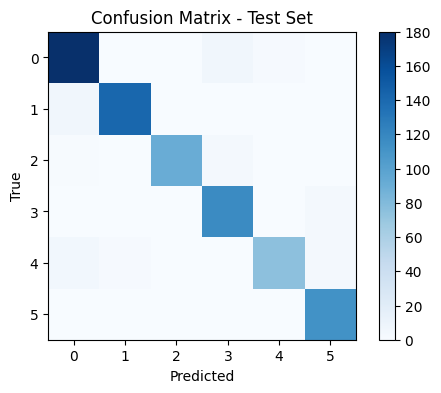

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import pyarrow.parquet as pq
import io
import scipy.signal
from PIL import Image

# Define dataset directories
data_csv = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
parquet_dir = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms"

# Load metadata
df = pd.read_csv(data_csv)

# Filter rows that have corresponding parquet files
existing_files = set(os.listdir(parquet_dir))
df = df[df["spectrogram_id"].apply(lambda x: f"{x}.parquet" in existing_files)]

# Limit to first 5000 samples
df = df.head(5000)

if df.empty:
    raise ValueError("No matching parquet files found. Check your directory and filenames.")

# Encode labels
y = df["expert_consensus"].dropna()
df = df.loc[y.index]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Metadata features
X_meta = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].values
scaler = StandardScaler()
X_meta = scaler.fit_transform(X_meta)

# Helper to convert spectrogram parquet to image array
def load_spectrogram_as_image(spectrogram_id, size=(224, 224)):
    file_path = os.path.join(parquet_dir, f"{spectrogram_id}.parquet")
    table = pq.read_table(file_path)
    data = table.to_pandas().values.T  # Transpose to get (freq, time)
    data = np.log1p(data)
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    img = Image.fromarray(np.uint8(data * 255)).convert("RGB").resize(size)
    return np.array(img) / 255.0

# Load spectrogram images
X_images = np.stack([load_spectrogram_as_image(sid) for sid in df["spectrogram_id"]])

# Split dataset
X_img_train, X_img_temp, X_meta_train, X_meta_temp, y_train, y_temp = train_test_split(
    X_images, X_meta, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical)
X_img_val, X_img_test, X_meta_val, X_meta_test, y_val, y_test = train_test_split(
    X_img_temp, X_meta_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define RetNet-inspired image model 
from tensorflow.keras.applications import ResNet50

image_input = keras.Input(shape=(224, 224, 3), name="image_input")
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
image_features = layers.Dropout(0.3)(x)

# Metadata model
meta_input = keras.Input(shape=(X_meta.shape[1],), name="meta_input")
y_meta = layers.Dense(32, activation='relu')(meta_input)
meta_features = layers.Dense(16, activation='relu')(y_meta)

# Merge models
merged = layers.concatenate([image_features, meta_features])
z = layers.Dense(64, activation='relu')(merged)
out = layers.Dense(y_categorical.shape[1], activation='softmax')(z)

model = keras.Model(inputs=[image_input, meta_input], outputs=out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(
    x=[X_img_train, X_meta_train],
    y=y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_img_val, X_meta_val], y_val)
)

# Evaluate model
y_pred = model.predict([X_img_test, X_meta_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Test Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("Test Report:\n", classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
plt.figure(figsize=(6, 4))
plt.imshow(confusion_matrix(y_true_classes, y_pred_classes), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [16]:
import tensorflow.keras.backend as K
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv2d_2", pred_index=None):
    # Build a model that maps the inputs to the activations of the last conv layer and output
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    # Dummy metadata input of correct shape (1, 6)
    dummy_meta = np.zeros((1, 6))

    # Compute the gradient of the top predicted class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_array, dummy_meta])
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradient of the output neuron w.r.t. the conv layer output
    grads = tape.gradient(class_channel, conv_outputs)

    # Global average pooling on the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the conv layer outputs with the pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [17]:
def display_gradcam(image, heatmap, alpha=0.4):
    image_uint8 = np.uint8(255 * image)
    heatmap_uint8 = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = np.array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + image_uint8
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


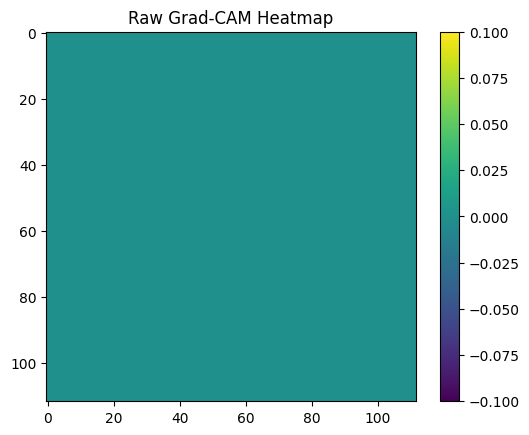

<ipython-input-17-72605467c2f6>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


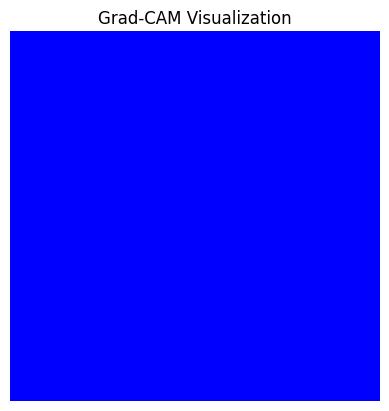

In [22]:
# Choose a sample from the test set
sample_index = 0
sample_img = X_img_test[sample_index:sample_index+1]     # shape: (1, 224, 224, 3)
sample_meta = X_meta_test[sample_index:sample_index+1]   # shape: (1, 6)

# Predict the class
predicted_class = np.argmax(model.predict([sample_img, sample_meta]))

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(sample_img, model, last_conv_layer_name="conv2d_1", pred_index=predicted_class)

plt.imshow(heatmap, cmap='viridis')
plt.title("Raw Grad-CAM Heatmap")
plt.colorbar()
plt.show()

# Display the Grad-CAM result
display_gradcam(sample_img[0], heatmap)


In [42]:
def predict_fn(imgs):
    meta_dummy = np.zeros((imgs.shape[0], 6))  # Replace 6 with number of metadata features
    return model.predict([imgs, meta_dummy])


In [43]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()


In [46]:
from skimage.segmentation import quickshift
sample_index = 0
sample_img = X_img_test[sample_index:sample_index+1]

explanation = explainer.explain_instance(
    image=np.array(sample_img[0]),
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=lambda x: quickshift(x, kernel_size=2, max_dist=10, ratio=0.2)
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

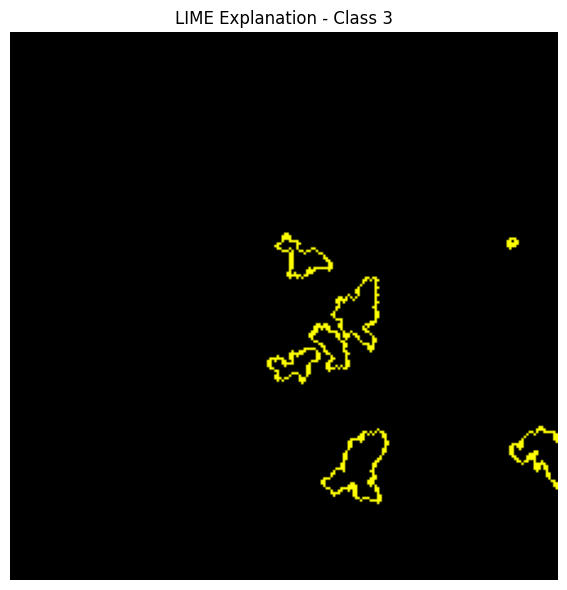

In [47]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

predicted_class = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=predicted_class,
    positive_only=True,
    num_features=8,
    hide_rest=False
)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mark_boundaries(temp / 255.0, mask))
ax.set_title(f"LIME Explanation - Class {predicted_class}")
ax.axis('off')
plt.tight_layout()
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

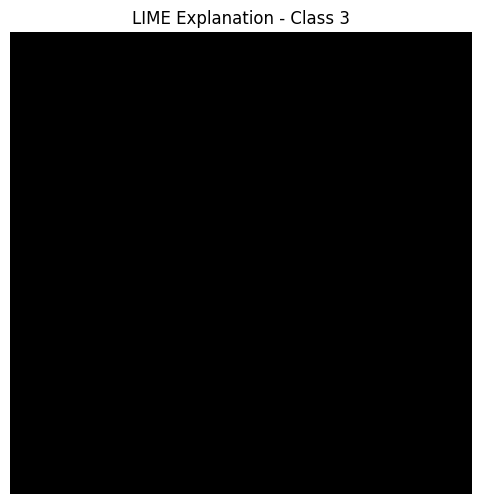

In [52]:
from lime import lime_image
from skimage.segmentation import quickshift, mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Pick test sample and original image
sample_index = 0
sample_img = X_img_test[sample_index:sample_index+1]  # (1, 224, 224, 3)
original_img = sample_img[0]

# Step 2: Ensure image is in uint8 format (0–255)
if original_img.max() <= 1.0:
    display_img = (original_img * 255).astype(np.uint8)
else:
    display_img = original_img.astype(np.uint8)

# Step 3: LIME explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=display_img,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=lambda x: quickshift(x, kernel_size=2, max_dist=10, ratio=0.2)
)

# Step 4: Get mask for most important regions
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=5,
    min_weight=0.0
)

# Step 5: Plot overlay of original image + LIME boundary
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(display_img, mask))  # NOT temp — we show original image with mask
plt.title(f"LIME Explanation - Class {explanation.top_labels[0]}")
plt.axis('off')
plt.show()
